In [1]:
import argparse
import json
import os
import sys
import time
from tqdm import tqdm
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, NumbaWarning
import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaWarning)

import numpy as np
import torch
from pathlib import Path
import yaml
from det3d import torchie
from det3d.datasets import build_dataloader, build_dataset
from det3d.models import build_detector
from det3d.torchie import Config
from det3d.torchie.apis import (
    batch_processor,
    build_optimizer,
    get_root_logger,
    init_dist,
    set_random_seed,
    train_detector,
)
from det3d.torchie.trainer import load_checkpoint
import torch.distributed as dist
import subprocess

# 주피터 노트북 경로설정
os.chdir('../')

def parse_args():
    parser = argparse.ArgumentParser(description="Train a detector")
    parser.add_argument("--config", default="configs/onlypoints/pp/onlypoints_centerpoint_pp.py", help="train config file path")
    parser.add_argument("--work_dir", help="the dir to save logs and models")
    parser.add_argument("--resume_from", help="the checkpoint file to resume from")
    parser.add_argument(
        "--validate",
        action="store_true",
        help="whether to evaluate the checkpoint during training",
    )
    parser.add_argument(
        "--gpus",
        type=int,
        default=1,
        help="number of gpus to use " "(only applicable to non-distributed training)",
    )
    parser.add_argument("--seed", type=int, default=None, help="random seed")
    parser.add_argument(
        "--launcher",
        choices=["pytorch", "slurm"],
        default="pytorch",
        help="job launcher",
    )
    parser.add_argument("--local_rank", type=int, default=0)
    parser.add_argument(
        "--autoscale-lr",
        action="store_true",
        help="automatically scale lr with the number of gpus",
    )
    args = parser.parse_args(args=[])
    if "LOCAL_RANK" not in os.environ:
        os.environ["LOCAL_RANK"] = str(args.local_rank)

    return args
args = parse_args()
cfg = Config.fromfile(args.config)
# distribution 설정 안함
cfg.local_rank = args.local_rank 

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
no apex
No Tensorflow
Deformable Convolution not built!
No APEX!


In [2]:
# init logger before other steps
distributed = False
cfg.gpus = args.gpus
logger = get_root_logger(cfg.log_level)
logger.info("Distributed training: {}".format(distributed))
logger.info(f"torch.backends.cudnn.benchmark: {torch.backends.cudnn.benchmark}")

2024-04-19 10:41:45,986 - INFO - Distributed training: False
2024-04-19 10:41:45,987 - INFO - torch.backends.cudnn.benchmark: False


In [3]:
model = build_detector(cfg.model, train_cfg=None, test_cfg=cfg.test_cfg)

2024-04-19 10:41:50,327 - INFO - Finish RPN Initialization
2024-04-19 10:41:50,328 - INFO - num_classes: [2, 2, 1, 1, 2, 1]
2024-04-19 10:41:50,344 - INFO - Finish CenterHead Initialization


Use HM Bias:  -2.19


In [4]:
args.testset = False
dataset = build_dataset(cfg.data.test)

In [5]:
args.speed_test = True
data_loader = build_dataloader(
        dataset,
        batch_size=cfg.data.samples_per_gpu if not args.speed_test else 1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=distributed,
        shuffle=False,
    )

In [6]:
args.checkpoint = "modelzoo/etri3D_pointpillar/etri3D_latest.pth"
checkpoint = load_checkpoint(model, args.checkpoint, map_location="cpu")

In [7]:
model = model.cuda()
model.eval()
mode = "test"

In [8]:
logger.info(f"work dir: {args.work_dir}")
if cfg.local_rank == 0:
    prog_bar = torchie.ProgressBar(len(data_loader.dataset) // cfg.gpus)

detections = {}
cpu_device = torch.device("cpu")

start = time.time()

start = int(len(dataset) / 3)
end = int(len(dataset) * 2 /3)

time_start = 0 
time_end = 0 

2024-04-16 16:35:29,803 - INFO - work dir: None


[                              ] 0/601, elapsed: 0s, ETA:

In [6]:
print(dataset[0])

{'metadata': {'data_root': PosixPath('data/test'), 'image_prefix': PosixPath('camera'), 'pcd_prefix': PosixPath('pcd'), 'num_point_features': 3, 'filename': PosixPath('20220915_115116_72.pcd')}, 'points': array([[ 8.678994  , -1.6336385 ,  2.3549724 ],
       [ 8.779579  , -1.6541581 ,  2.2127743 ],
       [ 8.716887  , -1.6423465 ,  2.0318856 ],
       ...,
       [-2.448703  , -0.43309432, -0.62480253],
       [-2.2852163 , -0.40459028, -0.627144  ],
       [-2.1262631 , -0.3764481 , -0.6251372 ]], dtype=float32), 'voxels': array([[[  8.678994  ,  -1.6336385 ,   2.3549724 ],
        [  8.779579  ,  -1.6541581 ,   2.2127743 ],
        [  8.716887  ,  -1.6423465 ,   2.0318856 ],
        ...,
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ]],

       [[  8.839134  ,  -1.6653789 ,   1.894487  ],
        [  8.924879  ,  -1.6654094 ,  -0.48724782],
        [  8.839134  ,  -1.6653789 , 

In [10]:
input_output = {"file_name": [], "points": [], "gt_boxes": [], "gt_classes": [], "output_boxes": [], "output_classes": [], "output_scores": []}
for i, data_batch in tqdm(enumerate(data_loader)):
    if i == start:
        torch.cuda.synchronize()
        time_start = time.time()

    if i == end:
        torch.cuda.synchronize()
        time_end = time.time()

    with torch.no_grad():
        outputs = batch_processor(
            model, data_batch, train_mode=False, local_rank=args.local_rank,
        )
    for j, output in enumerate(outputs):
        input_output["points"].append(data_batch['points'][j].cpu().numpy())
        input_output["file_name"].append(data_batch['metadata'][j]['filename'])
        # gt_boxes = []
        # for ts in data_batch['anno_box']:
        #     ts2 = ts[j]
        #     gt_boxes.extend(ts2.cpu().numpy())
        # input_output["gt_boxes"].append(np.array(gt_boxes))
        # gt_classes = []
        # idx = 0
        # for k in range(data_batch["anno_cls"][j].shape[0]):
        #     head_classes = cfg.tasks[k]
        #     class_names = head_classes['class_names']
        #     head_class_ids = data_batch['anno_cls'][j][k]
        #     for l in range(len(head_class_ids)):
        #         _id = head_class_ids[l] - 1
        #         gt_classes.append(idx+_id)
        #     idx += len(class_names)
        input_output["output_classes"].append(output['label_preds'].cpu().numpy())
        # input_output["gt_classes"].append(np.array(gt_classes))
        input_output["output_boxes"].append(output["box3d_lidar"].cpu().numpy())
        input_output["output_scores"].append(output['scores'].cpu().numpy())

0it [00:00, ?it/s]/home/jaelee/anaconda3/envs/centerpoint/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
601it [00:10, 55.31it/s]


In [52]:
len(input_output["file_name"])

601

In [59]:
import matplotlib.pyplot as plt
import cv2
import PIL
import open3d as o3d
line_list = [[0, 1],
             [1, 2],
             [2, 3],
             [3, 0],
             [4, 5],
             [5, 6],
             [6, 7],
             [7, 4],
             [0, 4],
             [1, 5],
             [2, 6],
             [3, 7]]
calib = np.array([[-0.99983949, -0.01008867, -0.01480574, 0.05565861],
[0.01433594, 0.04514753, -0.99887746, 0.08249057],
[0.01074579, -0.99892939, -0.04499565, -0.00898347],
[0, 0, 0, 1]])
# calib = np.linalg.inv(calib)
cam = np.array([[1076.7392578125, 0.0, 957.8059692382812],
[0.0, 1076.7392578125, 546.310791015625],
[0.0, 0.0, 1.0]])

for idx1 in range(len(input_output["file_name"])):
        points_v = input_output["points"][idx1]
        pred_boxes = input_output["output_boxes"][idx1]
        scores = input_output["output_scores"][idx1]
        boxes3d_pts_list = []
        
        file = Path("data/test/camera")/input_output["file_name"][idx1].with_suffix('.png')
        img = np.array(PIL.Image.open(file), dtype=np.uint8)

        for idx2 in range(len(pred_boxes)):
                # if scores[idx] < 0.1:
                #         continue
                if input_output["output_classes"][idx1][idx2] != 8:
                        continue
                translation = pred_boxes[idx2][:3]
                w, l, h = pred_boxes[idx2][3], pred_boxes[idx2][4], pred_boxes[idx2][5]
                rotation = pred_boxes[idx2][-1]

                bounding_box = np.array([
                                [-l/2, -l/2, l/2, l/2, -l/2, -l/2, l/2, l/2],
                                [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2],
                                [-h/2, -h/2, -h/2, -h/2, h/2, h/2, h/2, h/2]]) 
                rotation_matrix = np.array([
                        [np.cos(rotation), -np.sin(rotation), 0.0],
                        [np.sin(rotation), np.cos(rotation), 0.0],
                        [0.0, 0.0, 1.0]])
                eight_points = np.tile(translation, (8, 1))

                corner_box = np.dot(rotation_matrix, bounding_box) + eight_points.transpose()
                boxes3d_pts = corner_box.transpose()
                boxes3d_pts = boxes3d_pts.T
                boxes3d_pts = o3d.utility.Vector3dVector(boxes3d_pts.T)
                boxes3d_pts_list.append(np.asarray(boxes3d_pts))



        for j in range(len(boxes3d_pts_list)):
                # box_pt: (8, 3)
                boxes3d_pts_list[j] = np.concatenate((boxes3d_pts_list[j], np.ones((boxes3d_pts_list[j].shape[0], 1))), axis=1)
                boxes3d_pts_list[j] = np.matmul(cam, np.matmul(calib, boxes3d_pts_list[j].T).T[:, :3].T).T
                
                for k in range(boxes3d_pts_list[j].shape[0]):
                        boxes3d_pts_list[j][k, 0] = boxes3d_pts_list[j][k, 0] / boxes3d_pts_list[j][k, 2]
                        boxes3d_pts_list[j][k, 1] = boxes3d_pts_list[j][k, 1] / boxes3d_pts_list[j][k, 2]
                        boxes3d_pts_list[j][k, 2] = 1
                print(boxes3d_pts_list[j])
                for l in range(len(line_list)):
                        pnts = line_list[l]
                        cv2.line(img, (boxes3d_pts_list[j][pnts[0], 0].astype(np.int32), boxes3d_pts_list[j][pnts[0], 1].astype(np.int32)), (boxes3d_pts_list[j][pnts[1], 0].astype(np.int32), boxes3d_pts_list[j][pnts[1], 1].astype(np.int32)), (0, 255, 0), 2)
        plt.imsave(f"/home/jaelee/objdect/CenterPoint/plot_results/" + str(input_output["file_name"][idx1].with_suffix('.png')), img)

[[-8.20787865e+02  9.74083607e+02  1.00000000e+00]
 [-1.50716573e+03  1.14308836e+03  1.00000000e+00]
 [-1.19646443e+03  1.18036520e+03  1.00000000e+00]
 [-5.60916412e+02  9.92706183e+02  1.00000000e+00]
 [-8.64050637e+02  4.97921425e+02  1.00000000e+00]
 [-1.58509656e+03  4.98853552e+02  1.00000000e+00]
 [-1.27071883e+03  4.91597811e+02  1.00000000e+00]
 [-6.00846307e+02  4.92648210e+02  1.00000000e+00]]
[[-2.01381061e+03  1.08809837e+03  1.00000000e+00]
 [-2.87966299e+03  1.19887313e+03  1.00000000e+00]
 [-4.71730369e+03  1.59469435e+03  1.00000000e+00]
 [-3.06088078e+03  1.34743411e+03  1.00000000e+00]
 [-2.09437262e+03  5.22231552e+02  1.00000000e+00]
 [-2.99992551e+03  5.31814503e+02  1.00000000e+00]
 [-4.99380395e+03  5.46614016e+02  1.00000000e+00]
 [-3.21575934e+03  5.29232550e+02  1.00000000e+00]]
[[2.49436204e+03 7.37349589e+02 1.00000000e+00]
 [2.38678851e+03 7.45249175e+02 1.00000000e+00]
 [2.67085455e+03 7.88058175e+02 1.00000000e+00]
 [2.78893787e+03 7.77637969e+02 1.0000

In [57]:
str(input_output["file_name"][0].with_suffix('.png'))

'20220915_115614_11.png'

In [11]:
input_output["output_classes"][1]

array([1, 1, 4, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])

[Open3D INFO] Window window_42 created.


WebVisualizer(window_uid='window_42')

(-0.5, 1919.5, 1079.5, -0.5)

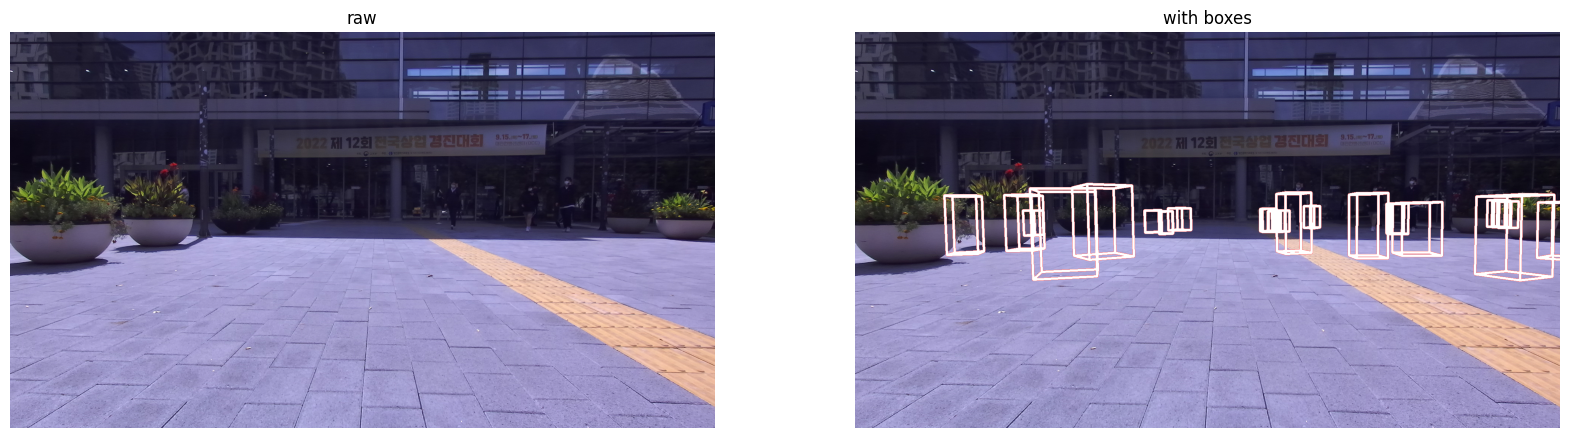

[Open3D INFO] Sending init frames to window_42.


[2857:259][1002421] (stun_port.cc:96): Binding request timed out from 10.42.0.x:56271 (enp5s0)
[2857:262][1002421] (stun_port.cc:96): Binding request timed out from 10.42.0.x:56271 (enp5s0)
[2887:081][1002421] (stun_port.cc:96): Binding request timed out from 10.42.0.x:39500 (enp5s0)
[2887:143][1002421] (stun_port.cc:96): Binding request timed out from 10.42.0.x:39500 (enp5s0)


In [102]:
import open3d as o3d
from open3d.web_visualizer import draw
import copy

i = np.random.randint(0, 600)
# i = 99
points_v = input_output["points"][i]
pred_boxes = input_output["output_boxes"][i]
scores = input_output["output_scores"][i]
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=2, origin=[0,0,0])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_v)
entities_to_draw = [pcd, mesh_frame]
boxes3d_pts_list = []
# pred_boxes 그리기
for idx in range(len(pred_boxes)):
        # if scores[idx] < 0.1:
        #         continue
        if input_output["output_classes"][i][idx] != 8:
                continue
        translation = pred_boxes[idx][:3]
        w, l, h = pred_boxes[idx][3], pred_boxes[idx][4], pred_boxes[idx][5]
        rotation = pred_boxes[idx][-1]

        bounding_box = np.array([
                        [-l/2, -l/2, l/2, l/2, -l/2, -l/2, l/2, l/2],
                        [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2],
                        [-h/2, -h/2, -h/2, -h/2, h/2, h/2, h/2, h/2]]) 
        rotation_matrix = np.array([
                [np.cos(rotation), -np.sin(rotation), 0.0],
                [np.sin(rotation), np.cos(rotation), 0.0],
                [0.0, 0.0, 1.0]])
        eight_points = np.tile(translation, (8, 1))

        corner_box = np.dot(rotation_matrix, bounding_box) + eight_points.transpose()
        boxes3d_pts = corner_box.transpose()
        boxes3d_pts = boxes3d_pts.T
        boxes3d_pts = o3d.utility.Vector3dVector(boxes3d_pts.T)
        boxes3d_pts_list.append(np.asarray(boxes3d_pts))
        box = o3d.geometry.OrientedBoundingBox.create_from_points(boxes3d_pts)
        box.color = [1, 0, 0]           #Box color would be red box.color = [R,G,B]
        entities_to_draw.append(box)
file = Path("data/test/camera")/input_output["file_name"][i].with_suffix('.png')
img = np.array(PIL.Image.open(file), dtype=np.uint8)
fig = plt.figure(figsize=(20,40))

img2 = copy.deepcopy(img)
for j in range(len(boxes3d_pts_list)):
        # box_pt: (8, 3)
        boxes3d_pts_list[j] = np.concatenate((boxes3d_pts_list[j], np.ones((boxes3d_pts_list[j].shape[0], 1))), axis=1)
        boxes3d_pts_list[j] = np.matmul(cam, np.matmul(calib, boxes3d_pts_list[j].T).T[:, :3].T).T
        
        for k in range(boxes3d_pts_list[j].shape[0]):
                boxes3d_pts_list[j][k, 0] = boxes3d_pts_list[j][k, 0] / boxes3d_pts_list[j][k, 2]
                boxes3d_pts_list[j][k, 1] = boxes3d_pts_list[j][k, 1] / boxes3d_pts_list[j][k, 2]
                boxes3d_pts_list[j][k, 2] = 1

        for l in range(len(line_list)):
                pnts = line_list[l]
                cv2.line(img2, (boxes3d_pts_list[j][pnts[0], 0].astype(np.int32), boxes3d_pts_list[j][pnts[0], 1].astype(np.int32)), (boxes3d_pts_list[j][pnts[1], 0].astype(np.int32), boxes3d_pts_list[j][pnts[1], 1].astype(np.int32)), (255, 0, 0), thickness = 5)
draw([*entities_to_draw])


rows = 1
cols = 2
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(img)
ax1.set_title('raw')
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(img2)
ax2.set_title('with boxes')
ax2.axis("off")

In [28]:
type(entities_to_draw[0])

open3d.cuda.pybind.geometry.PointCloud

In [29]:
type(entities_to_draw[1])

open3d.cuda.pybind.geometry.TriangleMesh

In [30]:
type(entities_to_draw[2])

open3d.cuda.pybind.geometry.OrientedBoundingBox

In [33]:
import PIL
import cv2
file = Path("data/test/camera")/input_output["file_name"][i].with_suffix('.png')
img = np.array(PIL.Image.open(file), dtype=np.uint8)



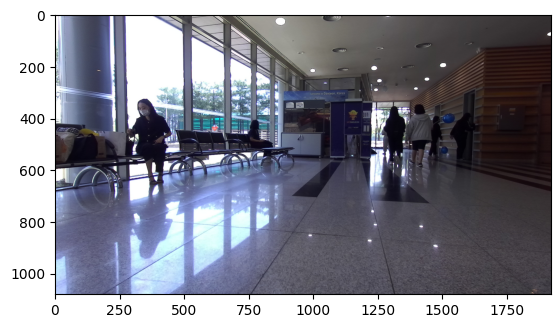

In [34]:
plt.imshow(img)

In [35]:
calib = np.array([[-0.99983949, -0.01008867, -0.01480574, 0.05565861],
[0.01433594, 0.04514753, -0.99887746, 0.08249057],
[0.01074579, -0.99892939, -0.04499565, -0.00898347],
[0, 0, 0, 1]])
# calib = np.linalg.inv(calib)
cam = np.array([[1076.7392578125, 0.0, 957.8059692382812],
[0.0, 1076.7392578125, 546.310791015625],
[0.0, 0.0, 1.0]])

In [36]:
points_v2 = points_v
# points_v2[:, 0] = - points_v[:, 0]

In [37]:
appended_points = np.concatenate((points_v2, np.ones((points_v2.shape[0], 1))), axis=1)

In [38]:
appended_points

array([[ 3.82483435, -0.71994483,  1.03783679,  1.        ],
       [ 3.84225821, -0.72391886,  0.96838927,  1.        ],
       [ 3.83159924, -0.7219106 ,  0.89313656,  1.        ],
       ...,
       [-2.59768844, -0.45944488, -0.662817  ,  1.        ],
       [-2.40689182, -0.4261325 , -0.66053599,  1.        ],
       [-2.24733138, -0.39788288, -0.66073221,  1.        ]])

In [39]:
calib.shape

(4, 4)

In [40]:
img_coord_pnts = np.matmul(cam, np.matmul(calib, appended_points.T).T[:, :3].T).T
# img_coord_pnts = np.matmul(calib, appended_points.T).T[:, :3]

In [41]:
for i in range(img_coord_pnts.shape[0]):
    img_coord_pnts[i, 0] = img_coord_pnts[i, 0] / img_coord_pnts[i, 2]
    img_coord_pnts[i, 1] = img_coord_pnts[i, 1] / img_coord_pnts[i, 2]
    img_coord_pnts[i, 2] = 1

In [42]:
img_coord_pnts

array([[-4.81358419e+03, -8.77719191e+02,  1.00000000e+00],
       [-4.77928231e+03, -7.58122025e+02,  1.00000000e+00],
       [-4.75135984e+03, -6.42408073e+02,  1.00000000e+00],
       ...,
       [ 7.31364509e+03,  2.18229694e+03,  1.00000000e+00],
       [ 7.29775923e+03,  2.30919073e+03,  1.00000000e+00],
       [ 7.28735938e+03,  2.43799655e+03,  1.00000000e+00]])

In [43]:
# (1080, 1920, 4)
(0 <= img_coord_pnts[:,0]) & (img_coord_pnts[:,0] < 1080) & (0 <= img_coord_pnts[:,1]) & (img_coord_pnts[:,1] < 1920)

array([False, False, False, ..., False, False, False])

In [44]:
img_coord_pnts[np.where((0 <= img_coord_pnts[:,0]) & (img_coord_pnts[:,0] < 1080) & (0 <= img_coord_pnts[:,1]) & (img_coord_pnts[:,1] < 1920))].shape, img_coord_pnts.shape

((15719, 3), (52916, 3))

In [45]:
np.where((0 <= img_coord_pnts[:,1]) & (img_coord_pnts[:,1] < 1920))[0].shape, np.where((0 <= img_coord_pnts[:,0]) & (img_coord_pnts[:,0] < 1080))[0].shape

((50458,), (15719,))

In [46]:
projected_pnts = img_coord_pnts[np.where((0 <= img_coord_pnts[:,1]) & (img_coord_pnts[:,1] < 1920))]

In [47]:
mesh_frame3= o3d.geometry.TriangleMesh.create_coordinate_frame(size=2, origin=[0,0,0])
pcd3 = o3d.geometry.PointCloud()
pcd3.points = o3d.utility.Vector3dVector(projected_pnts)
entities_to_draw3 = [pcd3, mesh_frame3]
draw([*entities_to_draw3])

[Open3D INFO] Window window_1 created.


WebVisualizer(window_uid='window_1')

[Open3D INFO] Sending init frames to window_1.


In [48]:
projected_pnts = projected_pnts.astype(np.int32)[:, :2]

In [49]:
# for j in range(projected_pnts.shape[0]):
#     tmp_img = cv2.line(img, (img_coord_pnts[j, 0].astype(np.int32), img_coord_pnts[j, 1].astype(np.int32)), (img_coord_pnts[j, 0].astype(np.int32), img_coord_pnts[j, 1].astype(np.int32)), (0, 0, 255), 2)

In [50]:
line_list = [[0, 1],
             [1, 2],
             [2, 3],
             [3, 0],
             [4, 5],
             [5, 6],
             [6, 7],
             [7, 4],
             [0, 4],
             [1, 5],
             [2, 6],
             [3, 7]]

for j in range(len(boxes3d_pts_list)):
    # box_pt: (8, 3)
    boxes3d_pts_list[j] = np.concatenate((boxes3d_pts_list[j], np.ones((boxes3d_pts_list[j].shape[0], 1))), axis=1)
    boxes3d_pts_list[j] = np.matmul(cam, np.matmul(calib, boxes3d_pts_list[j].T).T[:, :3].T).T
    
    for k in range(boxes3d_pts_list[j].shape[0]):
        boxes3d_pts_list[j][k, 0] = boxes3d_pts_list[j][k, 0] / boxes3d_pts_list[j][k, 2]
        boxes3d_pts_list[j][k, 1] = boxes3d_pts_list[j][k, 1] / boxes3d_pts_list[j][k, 2]
        boxes3d_pts_list[j][k, 2] = 1
    print(boxes3d_pts_list[j])
    for l in range(len(line_list)):
        pnts = line_list[l]
        cv2.line(img, (boxes3d_pts_list[j][pnts[0], 0].astype(np.int32), boxes3d_pts_list[j][pnts[0], 1].astype(np.int32)), (boxes3d_pts_list[j][pnts[1], 0].astype(np.int32), boxes3d_pts_list[j][pnts[1], 1].astype(np.int32)), (0, 255, 0), 2)

[[1.26101056e+03 5.76641959e+02 1.00000000e+00]
 [1.21640768e+03 5.74971221e+02 1.00000000e+00]
 [1.19010997e+03 5.78683600e+02 1.00000000e+00]
 [1.23580833e+03 5.80536324e+02 1.00000000e+00]
 [1.26080866e+03 4.82309676e+02 1.00000000e+00]
 [1.21604016e+03 4.83282450e+02 1.00000000e+00]
 [1.18962216e+03 4.83233441e+02 1.00000000e+00]
 [1.23549406e+03 4.82217919e+02 1.00000000e+00]]
[[1.40312029e+03 6.43654016e+02 1.00000000e+00]
 [1.45770948e+03 6.63308416e+02 1.00000000e+00]
 [1.61304973e+03 6.61900978e+02 1.00000000e+00]
 [1.53974355e+03 6.42324259e+02 1.00000000e+00]
 [1.40383052e+03 4.57886348e+02 1.00000000e+00]
 [1.45899957e+03 4.52557626e+02 1.00000000e+00]
 [1.61573011e+03 4.50036981e+02 1.00000000e+00]
 [1.54152809e+03 4.55692220e+02 1.00000000e+00]]
[[1.32600567e+03 5.84640732e+02 1.00000000e+00]
 [1.37313463e+03 5.84705915e+02 1.00000000e+00]
 [1.36486710e+03 5.80942526e+02 1.00000000e+00]
 [1.31975580e+03 5.80909653e+02 1.00000000e+00]
 [1.32605991e+03 4.91517750e+02 1.0000

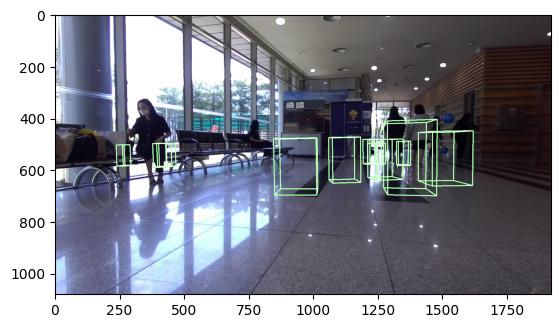

[066:254][1002421] (stun_port.cc:96): Binding request timed out from 10.42.0.x:45239 (enp5s0)
[066:254][1002421] (stun_port.cc:96): Binding request timed out from 10.42.0.x:45239 (enp5s0)


In [51]:
plt.imshow(img)